<a href="https://colab.research.google.com/github/quartermaine/Machine-Learning-Notebooks/blob/main/Clustering/Insurance_data_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### In this notebook, the primary objective was to conduct cluster analysis to discern distinctive characteristics of ideal customers. The analysis unfolded through the following steps:

- Data Preprocessing: Initially, the data underwent preprocessing to transform both categorical and numerical variables. This step ensured that the data were appropriately formatted and ready for subsequent analysis.


 - Determining Optimal Clusters: Next, the optimal number of clusters for K-means clustering was determined. By exploring different cluster configurations, we aimed to identify the most suitable number of clusters.

- Visualizing Clusters: Visualizations such as PCA (Principal Component Analysis) and T-SNE (t-distributed Stochastic Neighbor Embedding) were employed to visualize the clusters formed by the K-means algorithm. These techniques helped provide insights into the structure and distribution of the clusters.

- Feature Importance Analysis: Leveraging SHAP (SHapley Additive exPlanations) values, we conducted feature importance analysis for each cluster using the LGBM (Light Gradient Boosting Machine) algorithm. This analysis enabled us to identify the most influential features driving the characteristics of each cluster, thereby gaining deeper insights into customer segmentation.

- Metric Reporting: Finally, metrics were reported to evaluate the performance and effectiveness of the clustering analysis. These metrics provided valuable insights into the quality and interpretability of the generated clusters, facilitating informed decision-making and strategy formulation.


In [ ]:
#@title Libraries installation
%%capture
!pip install prince==0.12.1
!pip install shap==0.42.1
!pip install pyod==1.1.0
!pip install matplotlib==3.5.3
!pip install yellowbrick==1.5

In [ ]:
#@title Libraries Imports

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# lgb
import lightgbm as lgb
# data visualization
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap
# prince
import prince
# other
from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer
# pandas
import pandas as pd


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
#@title Function definitions

def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df,
                        x=columns[0],
                        y=columns[1],
                        z=columns[2],
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df,
                        x=columns[0],
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


In [ ]:
#@title Dataset Import

dataset = pd.read_csv("/content/insurance_data_sample.csv")

dataset.head()


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Amount_paid_for_insurance,Claim amount,City
0,C_CND_000001,01/02/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÃ‚Â Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,1665,0.0,Riga
1,C_CND_000002,01/02/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÃ‚Â Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,1332,1900.0,Liepaja
2,C_CND_000003,01/02/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,1897,0.0,Riga
3,C_CND_000004,01/02/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,1176,0.0,Jelgava
4,C_CND_000005,01/02/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÃ‚Â Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,1323,2450.0,Liepaja


In [ ]:
#@title Number of claims and not claims

df_pycaret = dataset.copy()

df_pycaret['claim amount bin'] = df_pycaret['Claim amount'].apply(lambda x: '0' if x == 0 else '1')

frequency_counts = df_pycaret['claim amount bin'].value_counts()

print(frequency_counts)


claim amount bin
0    21516
1     2390
Name: count, dtype: int64


In [ ]:
#@title Preprocessing

df_cl = dataset.copy()

df_cl = df_pycaret.drop(['Car_id', 'Date', 'Customer Name','Dealer_Name', 'Dealer_No ', 'Phone', ], axis=1)

# df_cl.head()


categorical_transformer_onehot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore",  drop="first",))
    ])

num = Pipeline(
    steps=[
        ("encoder", PowerTransformer())
    ])

preprocessor  = ColumnTransformer(transformers = [
                                        ('cat_onehot', categorical_transformer_onehot, ['Gender', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Body Style', 'City', 'claim amount bin']),
                                        ('num', num, ['Annual Income', 'Price ($)', 'Amount_paid_for_insurance', 'Claim amount'])
                                        ])

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor)]
    )
pipe_fit = pipeline.fit(df_cl)

# Fit the pipeline on the data
pipe_fit = pipeline.fit(df_cl)

# Transform the data
transformed_data = pipe_fit.transform(df_cl)

# Get the feature names after transformation
feature_names = pipe_fit.named_steps['preprocessor'].get_feature_names_out()

# Convert the transformed data from sparse to dense format
transformed_data_dense = transformed_data.toarray()

# Create DataFrame with transformed data
transformed_df = pd.DataFrame(transformed_data_dense, columns=feature_names)

# print(transformed_df.head())


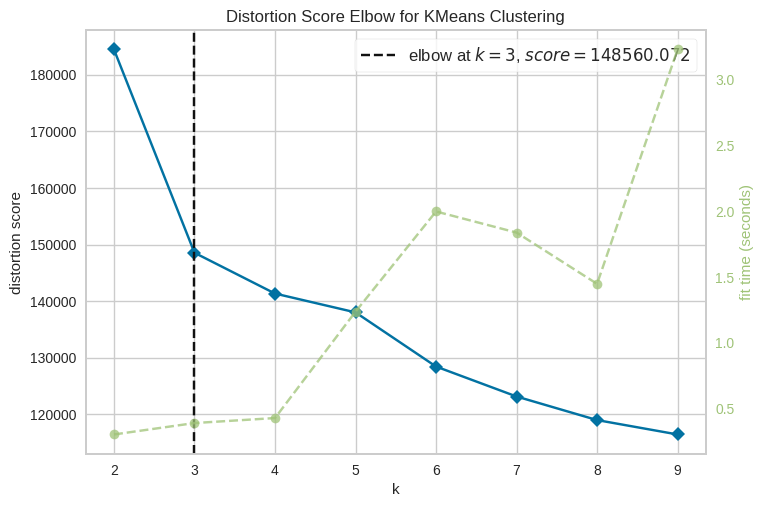

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#@title K-means Elbow

# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(transformed_df)        # Fit the data to the visualizer
visualizer.show()


In [ ]:
#@title Kmeans inertia

km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(transformed_data)
print(km.inertia_)


148560.0491964671


In [ ]:
#@title PCA 3D Plot

pca_3d_object, df_pca_3d = get_pca_3d(transformed_df, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :\n", pca_3d_object.eigenvalues_summary)


The variability is :
           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.744         1.37%                      1.37%
1              2.311         1.15%                      2.51%
2              2.286         1.14%                      3.65%


In [ ]:
#@title PCA 2D Plot

pca_2d_object, df_pca_2d = get_pca_2d(transformed_df, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)


In [ ]:
#@title T-SNE 3D Plot (takes much time to render)

sampling_data = transformed_df.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

# df_tsne_3d = TSNE(
#                   n_components=3,
#                   learning_rate=700,
#                   init='random',
#                   perplexity=100,
#                   n_iter = 1000).fit_transform(sampling_data)

# df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
# df_tsne_3d["cluster"] = sampling_clusters
# plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)


In [ ]:
#@title T-SNE 2D Plot

df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 1000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

# plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)



KeyboardInterrupt: 

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 23906, number of used features: 196
[LightGBM] [Info] Start training from score -1.059562
[LightGBM] [Info] Start training from score -0.591567
[LightGBM] [Info] Start training from score -2.303255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

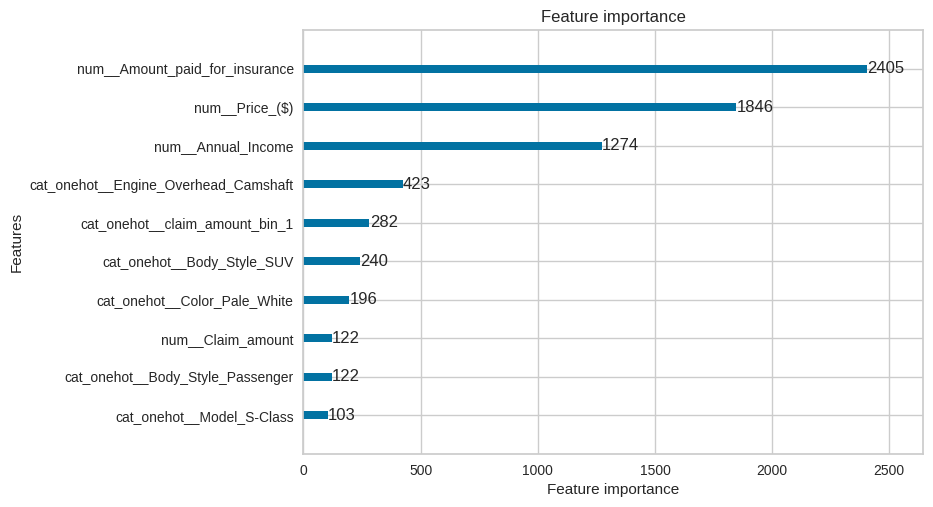

In [ ]:
#@title LGBM model and SHAP values

import lightgbm as lgb
import shap
from sklearn.preprocessing import LabelEncoder


clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

# for col in ['Gender', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Body Style', 'City', 'claim amount bin', 'Annual Income', 'Price ($)', 'Amount_paid_for_insurance']:
#     df_cl[col] = df_cl[col].astype('category')

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(clusters_predict)

clf_km.fit(X = transformed_df,
           y = y_encoded,
           feature_name = "auto",
           categorical_feature = "auto"
           )
# clf_km.fit(X = df_prueba, y = predict_embedding, feature_name='auto', categorical_feature = 'auto')

lgb.plot_importance(clf_km,
                    max_num_features=10
                    )


In [ ]:
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)

shap_values_km = explainer_km.shap_values(transformed_df)


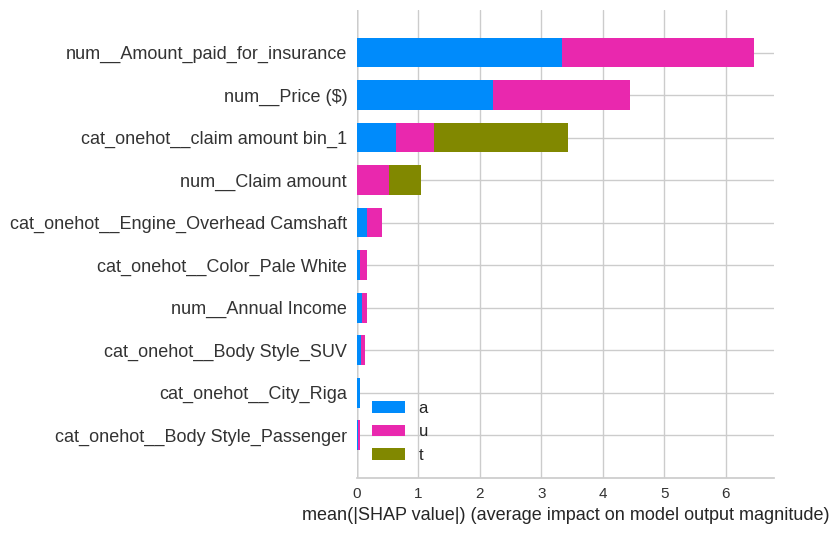

In [ ]:
shap.initjs()

shap.summary_plot(shap_values_km ,
                  transformed_df,
                  max_display=10,
                  plot_type="bar",
                  plot_size='auto',
                   class_inds="original",
                  class_names="auto"
                  )


In [ ]:
#@title Metrics

y_pred = clf_km.predict(transformed_df)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8286
           1       1.00      1.00      1.00     13231
           2       1.00      1.00      1.00      2389

    accuracy                           1.00     23906
   macro avg       1.00      1.00      1.00     23906
weighted avg       1.00      1.00      1.00     23906



### Key Findings from Cluster Analysis:

#### - **Optimal Clustering**: The analysis determined that the most suitable number of clusters for the dataset is 3, indicating distinct groupings within the data.

#### - **Significant Features**: Feature importance analysis highlighted several critical factors influencing insurance dynamics. Notably, "Amount Paid for Insurance," "Price," "Claim Amount," and "Annual Income" emerged as the most influential features. Clusters A and B exhibited dominance in "Amount Paid for Insurance" and "Price," suggesting higher spending tendencies. Moreover, "Amount Paid for Insurance" and "Annual Income" were identified as pivotal factors impacting insurance dynamics, wherein higher values correlate with greater customer value, complemented by higher prices and lower claim amounts

